- PassengerId 整型变量，标识乘客的ID，递增变量，对预测无帮助
- Survived 整型变量，标识该乘客是否幸存。0表示遇难，1表示幸存。将其转换为factor变量比较方便处理
- Pclass 整型变量，标识乘客的社会-经济状态，1代表Upper，2代表Middle，3代表Lower
- Name 字符型变量，除包含姓和名以外，还包含Mr.
- Mrs. Dr.这样的具有西方文化特点的信息
- Sex 字符型变量，标识乘客性别，适合转换为factor类型变量
- Age 整型变量，标识乘客年龄，有缺失值
- SibSp 整型变量，代表兄弟姐妹及配偶的个数。其中Sib代表Sibling也即兄弟姐妹，Sp代表Spouse也即配偶
- Parch 整型变量，代表父母或子女的个数。其中Par代表Parent也即父母，Ch代表Child也即子女
- Ticket 字符型变量，代表乘客的船票号 Fare 数值型，代表乘客的船票价
- Cabin 字符型，代表乘客所在的舱位，有缺失值
- Embarked 字符型，代表乘客登船口岸，适合转换为factor型变量

In [2]:
import numpy as np
from collections import Counter,defaultdict
import pandas #ipython notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("train.csv")
train.head(5)
test=pd.read_csv("test.csv")



In [63]:
# 数据预处理——Embarked
train['Embarked'].unique()
train['Embarked'].fillna('S',inplace=True)
test['Embarked'].fillna('S',inplace=True)
train['Embarked']=train['Embarked'].astype('category')
test['Embarked']=test['Embarked'].astype('category')
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

In [64]:
# 数据预处理——分割姓名称谓并统计数据
import re #正则表达式
name_pattern=re.compile('[A-Za-z]+\.?')
name_list= train['Name'].to_numpy()
words=Counter(word for name in name_list for word in re.findall(name_pattern,name))
words=list((-c,key) for key,c in words.items())
words.sort()
#展示name中单词的统计频次
for c,word in words[:50]:
    print("{:d}\t{}".format(-c,word))


517	Mr.
182	Miss.
125	Mrs.
64	William
44	John
40	Master.
35	Henry
24	Charles
24	George
24	James
22	Thomas
20	Mary
18	Edward
17	Anna
16	Joseph
15	Elizabeth
15	Frederick
15	Johan
14	Richard
13	Arthur
13	Samuel
12	Alfred
12	Margaret
11	Alexander
11	Maria
11	Peter
10	Jr
10	Robert
9	Andersson
9	Ernest
9	Karl
9	Leonard
9	O
8	Albert
8	Alice
8	Annie
8	H
8	J
8	Martin
8	Victor
7	Catherine
7	David
7	Dr.
7	Frank
7	Helen
7	Kate
7	Sage
7	de
6	Carter
6	E


In [65]:
#可以提取称谓作为新特征
title_list=tuple(w for c,w in filter(lambda cw:'.'==cw[1][-1] and -cw[0]>6,words))
def get_title(name_list):
    titleMatrix=[None]*len(title_list)
    for i,key in enumerate(title_list):
        titleMatrix[i]=list(int(key in name) for name in name_list)
    titleMatrix=pd.concat(tuple(map(pd.Series,titleMatrix)),axis=1)
    titleMatrix.columns=title_list
    return titleMatrix
train_titles=get_title(name_list)
test_titles=get_title(test['Name'].to_numpy())


In [66]:
# 去掉无效特征并添加新特征
drop_cols=['Name','Ticket','Cabin','PassengerId']
train=train.drop(drop_cols,axis=1)
train=pd.concat([train,train_titles],axis=1)
test=test.drop(drop_cols,axis=1)
test=pd.concat([test,test_titles],axis=1)
#数据浮点数化
train['Sex']=train['Sex'].map({'male':0,'female':1}).astype(int)
test['Sex']=test['Sex'].map({'male':0,'female':1}).astype(int)
# to_float_cols=["Pclass","Survived","SibSp","Parch"]
# for col in to_float_cols:
#     train[col].astype('float32')
#     test[col].astype('float32')

In [67]:
# train.describe()
# 训练年龄预测模型
naAge_train=train['Age'].isna()
naAge_test=test['Age'].isna()
# 注意预测age不能使用Survived属性
def getXYofAge(data:pd.DataFrame):
    column=list(data.columns)
    print(column)
    column.remove('Age')
    return data[column],data['Age']
    # return np.ndarray(data[column],dtype='float64'),np.ndarray(data['Age'],dtype='float64')
AgeTrainX,AgeTrainY=getXYofAge(train[test.columns].loc[~naAge_train])
AgeTestX,AgeTestY=getXYofAge(test.loc[~naAge_test])

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.']
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.']


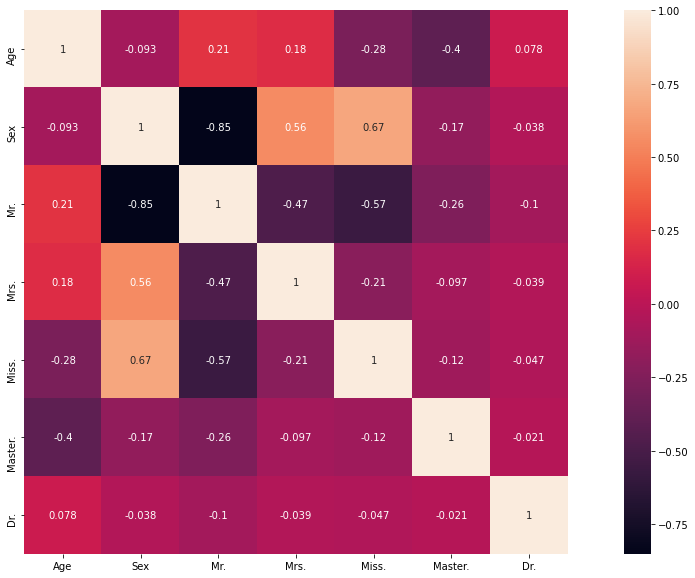

In [68]:
# 展示称谓特征及与性别和年龄的相关性
plt.figure(figsize=(20,10))
sns.heatmap(train[ ['Age','Sex','Mr.','Mrs.','Miss.','Master.','Dr.'] ].loc[~naAge_train].corr(),square=True,annot=True)

In [79]:
# 发现'Dr.'跟年龄相关性非常低，而 'Mr.'和'Master.'总是男性；'Mrs.','Miss.'总是女性。
# 这4个属性与性别高度冗余，可以设一个 title 属性，将 'Master.'和 'Miss.'映射为1，将'Mr.'和'Mrs.'映射为2，通过性别就可以完全区分开来。
# 其余称谓或无称谓一律映射为0。
def to_title(data:pd.DataFrame):
    change_coefficient={'Mr.':2,'Mrs.':2,'Miss.':1,'Master.':1}
    ret = np.zeros(shape=(data.shape[0],),dtype=np.int)
    for key,c in change_coefficient.items():
        ret+= data[key].to_numpy(dtype=np.int)*c
    return pd.Series(ret,name='Title')
AgeTrainX=pd.concat([AgeTrainX ,to_title(AgeTrainX)],axis=1)
AgeTestX=pd.concat([AgeTestX ,to_title(AgeTestX)],axis=1)

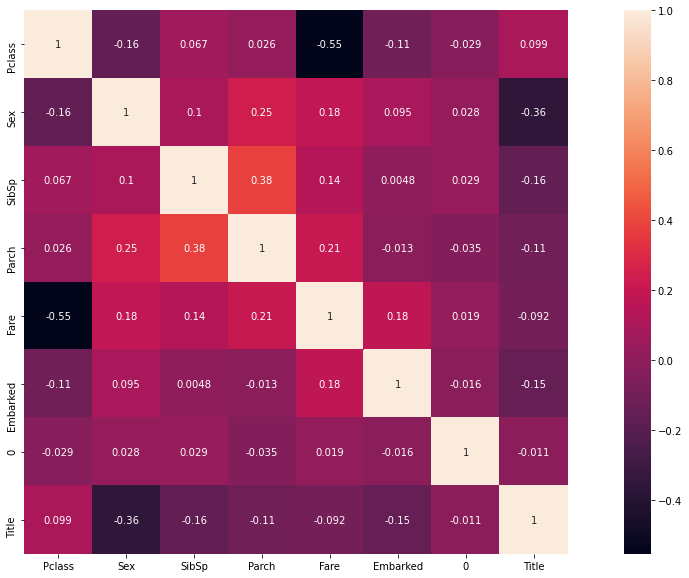

In [84]:
# 检查一下映射有没有出错
plt.figure(figsize=(20,10))
sns.heatmap(AgeTrainX.corr(),square=True,annot=True)

In [85]:
drop_col=['Mr.','Mrs.','Miss.','Master.','Dr.']
AgeTrainX=AgeTrainX.drop(['0'],axis=1)
AgeTestX=AgeTrainX.drop(['0'],axis=1)

KeyError: "['0'] not found in axis"

In [69]:
# 对年龄缺失值进行预测(包括原训练组和测试组)
params={
    'n_estimators':200,
    'objective':'binary:logistic',
    'max_depth':4,
    'learning_rate':0.1,
}
# python 语法，字典对象前加两个*可以转化成以key为参数名且对应value为参数值带入到方法参数列表中。
import xgboost as xgb
# 仅使用 train 数据集（Age非空的样本）训练预测 Age 的模型
model=xgb.XGBClassifier(**params).fit(AgeTrainX,AgeTrainY)
# 对 test数据集（Age非空的样本）的Age进行预测
y_test=model.predict(AgeTestX)

C:\Users\java_lee\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
# 展示对test数据集的年龄预测的效果
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in y_test]
# evaluate predictions
accuracy =  accuracy_score(AgeTestY, predictions)

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [29]:
_A=np.array(range(15)).reshape((5,3))
A=pd.DataFrame(_A,columns=['a','b','c'] )
A

,a,b,c
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11
4,12,13,14


In [30]:
idx=A['b'].loc[A['b']%2==1].index
L=pd.Series([-1,-2,-4],index=idx)
L

0   -1
2   -2
4   -4
dtype: int64

In [31]:
A['c'].loc[[1,2,4] ]=L
A

,a,b,c
0,0,1,2.0
1,3,4,NaN
2,6,7,-2.0
3,9,10,11.0
4,12,13,-4.0
